In [11]:
using Plots
using DataStructures

# 5. Monte Carlo Methods

Instead of computing $v_\pi$ using the given dynamics of an MDP, sample data to _estimate_ $v_\pi$ and use that estimate to perform policy iteration.

## 5.1  Monte Carlo Prediction

We need to learn $v_\pi(s)$ from samples of the MDP process with policy $\pi$.

We distinguish between two ways of estimating $v_\pi(s)$

1. Calculate the average return from trajectories after the _first_ occurrence of state $s$:

$$
\hat{v}_\pi(s) = \frac{1}{N}\sum_{n=1}^N{\sum_{i=k}^{T_n}{\gamma^{i-k}R^n_i}}
$$

Where $T_n$ is the length of episode $n$, and $k$ is the first index such that $S^n_k = s$

2. Calculate the average return from trajectories after _all_ occurences of state $s$

$$
\hat{v}_\pi(s) = \frac{1}{N(s)}\sum_{n,k}\sum_{i=k}^{T_n}{\gamma^{i-k}R^n_i}
$$

We can implement first visit Monte Carlo prediction with the following code

In [2]:
function first_visits(𝓢, S)
    d = Dict()
    for (i, s) in enumerate(S)
        if !haskey(d, s)
            d[s] = i
        end
        
        if length(d) == length(𝓢)
            return d
        end
    end
    return d
end

first_visits (generic function with 1 method)

In [3]:
using DataStructures

function first_visit_mc(𝓢, sampler; γ=1, iterations=1000)
    V = DefaultDict(0)
    N = DefaultDict(0)
    for n in 1:iterations
        S, A, R = sampler()
        visits = first_visits(𝓢, S)
        G = 0
        for i in length(S):-1:1
            G = γ*G + R[i]
            if haskey(visits, S[i]) && visits[S[i]] == i
                N[S[i]] += 1
                V[S[i]] += (1/N[S[i]])*(G - V[S[i]])
            end
        end
    end
    
    return V
end

first_visit_mc (generic function with 1 method)

### Example 5.1: Blackjack

In [28]:
function policy(s)
    hand, dealer, ace = s
    hand < 20 ? :hit : :stick
end

function rollout(π)
    S = Tuple{Int,Int,Bool}[]
    A = Symbol[]
    R = Int64[]
    draw() = min(rand(1:13), 10)
    value(ace, hand) = (ace && hand <= 11) ? hand + 10 : hand 
    dealer = draw()
    hand = [draw(), draw()]
    has_ace = hand[1] == 1 || hand[2] == 1
    hand = sum(hand)
    
    dealer_hand = [dealer, draw()]
    dealer_has_ace = dealer_hand[1] == 1 || dealer_hand[2] == 1
    dealer_hand = sum(dealer_hand)
    while value(dealer_has_ace, dealer_hand) < 17
        card = draw()
        dealer_has_ace = dealer_has_ace || card == 1
        dealer_hand += card
    end
    dealer_total = value(dealer_has_ace, dealer_hand)
    
    # Get up to > 11
    while value(has_ace, hand) <= 11
        card = draw()
        has_ace = has_ace || card == 1
        hand += card
    end
    
    push!(S, (value(has_ace, hand), dealer, has_ace && hand <= 11))
    action = π(S[1])
    push!(A, action)
    while action == :hit && hand <= 21
        card = draw()
        has_ace = has_ace || card == 1
        hand += card
        if hand > 21
            push!(R, -1)
            return S, A, R
        end
        push!(R, 0)
        push!(S, (value(has_ace, hand), dealer, has_ace && hand <= 11))
        action = π(S[end])
        push!(A, action)
    end
    player_total = value(has_ace, hand)

    if (hand > 21 && dealer_hand > 21)
        push!(R, 0)
    elseif hand > 21
        push!(R, -1)
    elseif dealer_hand > 21
        push!(R, 1)
    elseif player_total == dealer_total
        push!(R, 0)
    elseif player_total < dealer_total
        push!(R, -1)
    else player_total > dealer_total
        push!(R, 1)
    end

    return S, A, R
end

rollout (generic function with 1 method)

In [46]:
rollout(policy)

(Tuple{Int64, Int64, Bool}[(16, 10, 0)], [:hit], [-1])

In [5]:
𝓢 = [ (value, dealer, usable_ace) for value in 12:21, dealer in 1:10, usable_ace in [true, false]]

V1e4 = first_visit_mc(𝓢, () -> rollout(policy); γ=1, iterations=10_000)
V5e5 = first_visit_mc(𝓢, () -> rollout(policy); γ=1, iterations=500_000)

10×10×2 Array{Tuple{Int64, Int64, Bool}, 3}:
[:, :, 1] =
 (12, 1, 1)  (12, 2, 1)  (12, 3, 1)  …  (12, 8, 1)  (12, 9, 1)  (12, 10, 1)
 (13, 1, 1)  (13, 2, 1)  (13, 3, 1)     (13, 8, 1)  (13, 9, 1)  (13, 10, 1)
 (14, 1, 1)  (14, 2, 1)  (14, 3, 1)     (14, 8, 1)  (14, 9, 1)  (14, 10, 1)
 (15, 1, 1)  (15, 2, 1)  (15, 3, 1)     (15, 8, 1)  (15, 9, 1)  (15, 10, 1)
 (16, 1, 1)  (16, 2, 1)  (16, 3, 1)     (16, 8, 1)  (16, 9, 1)  (16, 10, 1)
 (17, 1, 1)  (17, 2, 1)  (17, 3, 1)  …  (17, 8, 1)  (17, 9, 1)  (17, 10, 1)
 (18, 1, 1)  (18, 2, 1)  (18, 3, 1)     (18, 8, 1)  (18, 9, 1)  (18, 10, 1)
 (19, 1, 1)  (19, 2, 1)  (19, 3, 1)     (19, 8, 1)  (19, 9, 1)  (19, 10, 1)
 (20, 1, 1)  (20, 2, 1)  (20, 3, 1)     (20, 8, 1)  (20, 9, 1)  (20, 10, 1)
 (21, 1, 1)  (21, 2, 1)  (21, 3, 1)     (21, 8, 1)  (21, 9, 1)  (21, 10, 1)

[:, :, 2] =
 (12, 1, 0)  (12, 2, 0)  (12, 3, 0)  …  (12, 8, 0)  (12, 9, 0)  (12, 10, 0)
 (13, 1, 0)  (13, 2, 0)  (13, 3, 0)     (13, 8, 0)  (13, 9, 0)  (13, 10, 0)
 (14, 1, 0)  (14, 

In [7]:
ace_V1e4 = [ V1e4[(i, j, true)] for i in 12:21, j in 1:10 ]
noace_V1e4 = [ V1e4[(i, j, false)] for i in 12:21, j in 1:10 ]
ace_V5e5 = [ V5e5[(i, j, true)] for i in 12:21, j in 1:10 ]
noace_V5e5 = [ V5e5[(i, j, false)] for i in 12:21, j in 1:10 ];

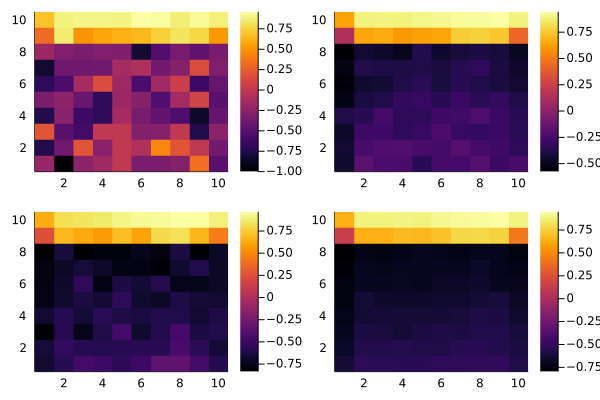

In [12]:
p1 = heatmap(ace_V1e4)
p2 = heatmap(noace_V1e4)
p3 = heatmap(ace_V5e5)
p4 = heatmap(noace_V5e5)

plot(p1, p3, p2, p4, layout=(2,2))

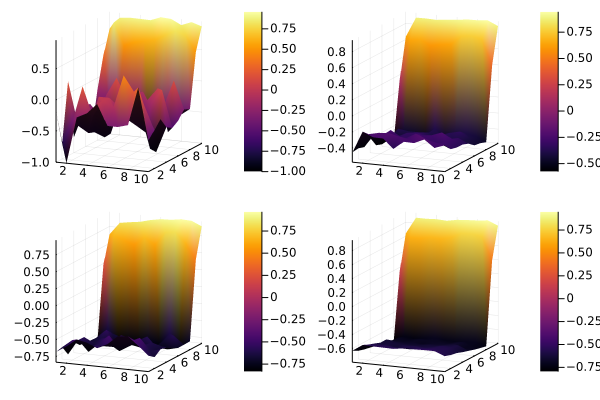

In [13]:
p1 = surface(ace_V1e4)
p2 = surface(noace_V1e4)
p3 = surface(ace_V5e5)
p4 = surface(noace_V5e5)

plot(p1, p3, p2, p4, layout=(2,2))

> _Exercise 5.1_ Consider the diagrams on the right in Figure 5.1. Why does the estimated value function jump up for the last two rows in the rear? Why does it drop off for the whole last row on the left? Why are the frontmost values higher in the upper diagrams than in the lower?

The estimated value function jumps for the last two rows since those two rows represent relatively high scores compared to the average dealer score, and additionally the policy "sticks" for these values, meaning we are likely to achieve those scores than busting.

The drop off on the left is because the dealer possesses an ace, which is a more valuable card since it can be used as either an 11 or a 1.

The value of the states in the bottom half of the figure are for the same reason. Having an ace allows you to "hit" more with less of a chance of busting.

> _Exercise 5.2_ Suppose every-visit MC was used instead of first-visit MC on the blackjack task. Would you expect the results to be very different? Why or why not?

I would not expect every-visit MC to be very different from the first-visit MC results. This is because the value of any state, as we have set it up here, is not affected by it's location in the sequence.

> _Exercise 5.3_ What is the backup diagram for Monte Carlo estimation of $q_\pi$?

The backup diagram for Monte Carlo $q_\pi$ estimation would be the same as the backup diagram for state-value estimation, since in either case we start with a particular state and action. In order to illustrate this one could somehow indicate that the initial state _and_ action are being evaluated, rather than just the particular state, perhaps by surrounding the state and action with a box.

> _Exercise 5.4_ The pseudocode for Monte Carlo ES is inefficient because, for each state–action pair, it maintains a list of all returns and repeatedly calculates their mean. It would be more efficient to use techniques similar to those explained in Section 2.4 to maintain just the mean and a count (for each state–action pair) and update them incrementally. Describe how the pseudocode would be altered to achieve this.

This can be achieved by simply mainting the current average values $Q(s, a)$, and the visit count to each state-action pair. Instead of recomputing the average, we compute:

$$
Q(s, a) \gets Q(s, a) + \frac{1}{N(s, a)}(G - Q(s, a))
$$

In [14]:
function first_visits(𝓢, 𝓐, S, A)
    visits = Dict()
    for i in eachindex(S)
        if !haskey(visits, (S[i], A[i]))
            visits[(S[i], A[i])] = i
        end
        
        if length(visits) == length(𝓢)*length(𝓐)
            return visits
        end
    end
    return visits
end

function monte_carlo_es(𝓢, 𝓐, init_sampler, sampler, π_init; γ=1, iterations=10000)
    π_dict = π_init
    π(s) = π_dict[s]
    Q = Dict((s, a) => 0.0 for s in 𝓢, a in 𝓐)
    N = Dict((s, a) => 0.0 for s in 𝓢, a in 𝓐)
    
    for i in 1:iterations
        s0, a0 = init_sampler()
        S, A, R = sampler(π, s0, a0)
        visits = first_visits(𝓢, 𝓐, S, A)
        G = 0
        for i in length(S):-1:1
            G = γ*G + R[i]
            if visits[(S[i], A[i])] == i
                N[S[i], A[i]] += 1
                Q[S[i], A[i]] += 1/(N[S[i], A[i]]) * (G - Q[S[i], A[i]])
                π_dict[S[i]] = argmax(a -> Q[S[i], a], 𝓐)
            end
        end
    end
    
    return Q, π_dict
end

π_init = Dict(s => policy(s) for s in 𝓢)
𝓐 = [:hit, :stick]

init_sampler() = (rand(𝓢), rand(𝓐))

function rollout_es(π, s0, a0)
    S = Tuple{Int,Int,Bool}[]
    A = Symbol[]
    R = Int64[]
    draw() = min(rand(1:13), 10)
    value(ace, hand) = (ace && hand <= 11) ? hand + 10 : hand 
    
    init_value, dealer, usable_ace = s0
    if usable_ace
        hand = init_value - 10
    else
        hand = init_value
    end
    has_ace = usable_ace
    
    dealer_hand = [dealer, draw()]
    dealer_has_ace = dealer_hand[1] == 1 || dealer_hand[2] == 1
    dealer_hand = sum(dealer_hand)
    while value(dealer_has_ace, dealer_hand) < 17
        card = draw()
        dealer_has_ace = dealer_has_ace || card == 1
        dealer_hand += card
    end
    dealer_total = value(dealer_has_ace, dealer_hand)
    
    push!(S, s0)
    push!(A, a0)
    
    action = a0
    while action == :hit && hand <= 21
        card = draw()
        has_ace = has_ace || card == 1
        hand += card
        if hand > 21
            push!(R, -1)
            return S, A, R
        end
        push!(R, 0)
        push!(S, (value(has_ace, hand), dealer, has_ace && hand <= 11))
        action = π(S[end])
        push!(A, action)
    end
    player_total = value(has_ace, hand)

    if (hand > 21 && dealer_hand > 21)
        push!(R, 0)
    elseif hand > 21
        push!(R, -1)
    elseif dealer_hand > 21
        push!(R, 1)
    elseif player_total == dealer_total
        push!(R, 0)
    elseif player_total < dealer_total
        push!(R, -1)
    else player_total > dealer_total
        push!(R, 1)
    end

    return S, A, R
end

rollout_es (generic function with 1 method)

In [15]:
Q, π_star = monte_carlo_es(𝓢, 𝓐, init_sampler, rollout_es, π_init; γ=1, iterations=5e5);

In [16]:
V = Dict(s => Q[s, π_star[s]] for s in 𝓢)

Dict{Tuple{Int64, Int64, Bool}, Float64} with 200 entries:
  (20, 8, 0)  => 0.787308
  (16, 10, 0) => -0.601218
  (19, 3, 1)  => 0.354839
  (16, 2, 0)  => -0.280174
  (15, 9, 0)  => -0.477281
  (19, 10, 0) => -0.0221122
  (19, 2, 0)  => 0.35709
  (17, 9, 1)  => -0.138969
  (13, 7, 1)  => 0.126178
  (17, 3, 0)  => -0.0974417
  (12, 6, 1)  => 0.153666
  (18, 10, 1) => -0.221921
  (18, 2, 1)  => 0.110852
  (20, 8, 1)  => 0.801828
  (16, 10, 1) => -0.258255
  (16, 2, 1)  => -0.0434527
  (20, 7, 0)  => 0.745154
  (15, 9, 1)  => -0.137752
  (15, 3, 0)  => -0.217391
  (19, 10, 1) => -0.0357647
  (19, 2, 1)  => 0.369789
  (17, 3, 1)  => 0.0684541
  (13, 9, 0)  => -0.4
  (17, 10, 0) => -0.465995
  (17, 2, 0)  => -0.181565
  ⋮           => ⋮

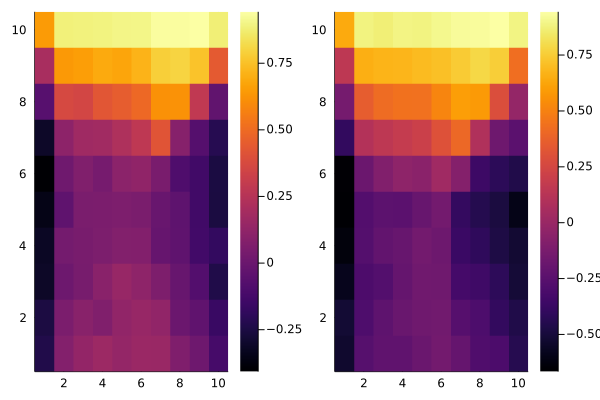

In [17]:
ace_V = [ V[(i, j, true)] for i in 12:21, j in 1:10 ]
noace_V = [ V[(i, j, false)] for i in 12:21, j in 1:10 ];

p3 = heatmap(ace_V)
p4 = heatmap(noace_V)

plot(p3, p4, layout=(1,2))

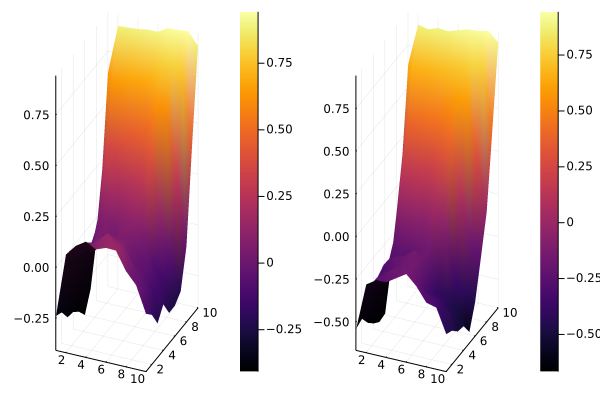

In [18]:
p1 = surface(ace_V)
p2 = surface(noace_V)

plot(p1, p2, layout=(1, 2))

In [19]:
ace_π = [ π_star[(i, j, true)] for i in 12:21, j in 1:10 ]
noace_π = [ π_star[(i, j, false)] for i in 12:21, j in 1:10 ];

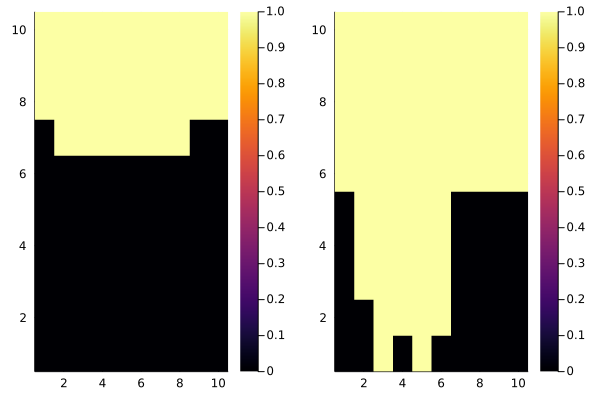

In [20]:
p1 = heatmap(ace_π .== :stick)
p2 = heatmap(noace_π .== :stick)

plot(p1, p2, layout=(1, 2))

In [23]:
function monte_carlo_es_epsilon_greedy(𝓢, 𝓐, sampler, π_init; γ=1, iterations=10000, ε=0.05)
    π_dict = π_init
    π(s) = rand() < ε ? rand(𝓐) : π_dict[s]
    Q = Dict((s, a) => 0.0 for s in 𝓢, a in 𝓐)
    N = Dict((s, a) => 0.0 for s in 𝓢, a in 𝓐)
    
    for i in 1:iterations
        S, A, R = sampler(π)
        visits = first_visits(𝓢, 𝓐, S, A)
        G = 0
        for i in length(S):-1:1
            G = γ*G + R[i]
            if visits[(S[i], A[i])] == i
                N[S[i], A[i]] += 1
                Q[S[i], A[i]] += 1/(N[S[i], A[i]]) * (G - Q[S[i], A[i]])
                π_dict[S[i]] = argmax(a -> Q[S[i], a], 𝓐)
            end
        end
    end
    
    return Q, π_dict
end

monte_carlo_es_epsilon_greedy (generic function with 1 method)

In [53]:
Q, π_dict = monte_carlo_es_epsilon_greedy(𝓢, 𝓐, rollout, π_init; γ=1, iterations=5e6)

(Dict{Tuple{Tuple{Int64, Int64, Bool}, Symbol}, Float64}(((14, 7, 0), :hit) => -0.33095301066737104, ((16, 7, 0), :stick) => -0.45612648221343866, ((19, 8, 1), :stick) => 0.5848370589819573, ((19, 5, 1), :hit) => 0.21469575200918486, ((20, 9, 0), :hit) => -0.861924686192469, ((15, 10, 1), :hit) => -0.24165723341634482, ((19, 7, 0), :stick) => 0.6140154431147526, ((15, 2, 1), :hit) => -0.017981651376146855, ((13, 3, 1), :hit) => 0.014285714285714284, ((17, 8, 0), :stick) => -0.3847799947011193…), Dict{Tuple{Int64, Int64, Bool}, Symbol}((20, 8, 0) => :stick, (16, 10, 0) => :stick, (19, 3, 1) => :stick, (16, 2, 0) => :stick, (13, 6, 1) => :hit, (15, 9, 0) => :hit, (19, 10, 0) => :stick, (19, 2, 0) => :stick, (17, 9, 1) => :hit, (13, 7, 1) => :hit…))

In [54]:
ace_π_eps = [ π_star[(i, j, true)] for i in 12:21, j in 1:10 ]
noace_π_eps = [ π_star[(i, j, false)] for i in 12:21, j in 1:10 ];

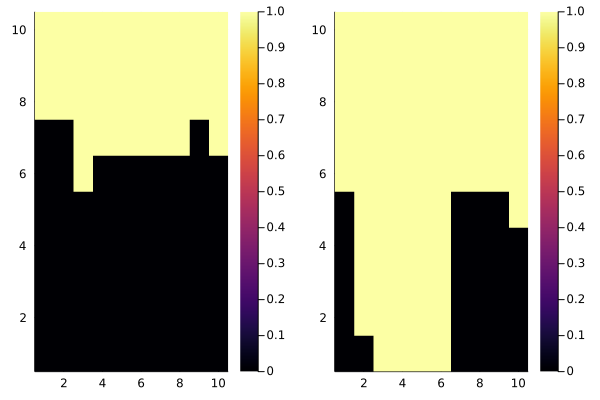

In [55]:
p1 = heatmap(ace_π_eps .== :stick)
p2 = heatmap(noace_π_eps .== :stick)

plot(p1, p2, layout=(1, 2))